In [1]:
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api.formatters import TextFormatter
from typing_extensions import TypedDict, Annotated
from urllib.parse import urlparse, parse_qs
import json

In [2]:
import os 
from langchain_groq import ChatGroq 
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# llm = ChatGroq(model='deepseek-r1-distill-llama-70b')
# llm = ChatGroq(model='gemma2-9b-it')
llm = ChatGroq(model='qwen-2.5-32b')

llm.invoke("What is your name?")

AIMessage(content='My name is Qwen. I am a large language model created by Alibaba Cloud.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 34, 'total_tokens': 52, 'completion_time': 0.09, 'prompt_time': 0.003987688, 'queue_time': 0.235814467, 'total_time': 0.093987688}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-0af94332-fba9-4866-ba62-f0e934344f39-0', usage_metadata={'input_tokens': 34, 'output_tokens': 18, 'total_tokens': 52})

In [3]:
class BlogState(TypedDict):
    video_url : str
    transcript : Annotated[str, 'add_transcript']
    summary : Annotated[str, 'add_summary']
    blog_post : Annotated[str, "add_post"]
    review_approved : bool
    human_feedback : str

In [4]:
def extract_video_id(video_url : str) -> str:
    url_parsed = urlparse(video_url)
    query_params = parse_qs(url_parsed.query)

    if "v" in query_params:
        video_id = query_params["v"][0]

    elif url_parsed.netloc in ["youtu.be", "www.youtube.com", "youtube.com"] and url_parsed.path: 
        video_id = url_parsed.path.split("/")[-1]

    else:
        raise ValueError("Invalid Youtube URL format")
    
    return video_id

In [5]:
def extract_transcript(state : BlogState) -> BlogState:
    video_url = state['video_url']
    print(f"Extracting transcript for video URL: {video_url}")

    try:
        video_id = extract_video_id(video_url)
        transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=['en'])
        formatter = TextFormatter()
        transcript_formatted = formatter.format_transcript(transcript)
        state['transcript'] = transcript_formatted
        print(f"Transcript successfully extracted : {transcript_formatted[:100]}...")
    
    except Exception as e:
        state['transcript'] = f"Error : {str(e)}"
        print(f"Error in extracting transcript : {str(e)}")

    return state

In [6]:
def summarize_transcript(state : BlogState) -> BlogState:
    print("\n----- In Summarize transcript -----\n")
    transcript = state['transcript']
    prompt = f"""
    
    Summarize the following Youtube Transcript while maintains key insights. 

    Return ONLY a valid JSON object like this:
        {{
            "summary_text" : "Breif summary here...",
            "key_points" : ["Point 1", "Point 2", "Point 3"]
        }}

    Do NOT incliude extract text before and after the JSON. Just return the JSON

    Transcript: 
    
    {transcript}
    """

    try:
        summary_msg = llm.invoke(prompt)
        summary_json = summary_msg.content # extract the content from AIMessage 
        summary = json.loads(summary_json)

        if isinstance(summary, dict) and "summary_text" in summary and "key_points" in summary:
            state['summary'] = summary
            print(f"Summary successfully generated : {summary}")        

        else:
            raise ValueError("Invalid summary format")
        
    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error in generating summary : {str(e)}")
        state['summary'] = {"summary_text" : "Error in generating summary", "key_points" : []}

    return state

In [7]:
def generate_blog(state: BlogState) -> BlogState:
    print("\n----- In Generate Blog -----\n")

    blog_summary = state['summary']
    prompt = f"""

    Convert the following summarized transcript into a well-structed blog post.

    The blog should be engaging, informative and well-structed with an introduction, key takeaway and a conclusion. 

    Return ONLY a valid JSON object formatted as follows (No extra text outside JSON):
        {{
            "title" : "Your Title Here", 
            "introduction: "Introduction text here...",
            "content: "Main blog content here...",
            "conclusion: "Conclusion here..."
        }}

    Here is the transcript summary : 
    
    {blog_summary}
    """

    try:
        blog_message = llm.invoke(prompt)
        blog_content = blog_message.content
        blog_post = json.loads(blog_content)

        if isinstance(blog_post , dict) and all(key in blog_post for key in ["title", "introduction", "content", "conclusion"]):
            state['blog_post'] = blog_post
            print(f"Blog post generated successfully : {blog_post}")
        else:
            raise ValueError("Invalid blog post format.")
        
    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error in generating blog post : {str(e)}")
        state['blog_post'] = {
            "title" : "Error",
            "introduction" : "There was an error in generating the blog post.",
            "content" : "",
            "conclusion" : ""
        }
    
    return state

In [8]:
def human_review(state : BlogState) -> BlogState:
    print("\n----- In Blog Review -----\n")
    decision = input("\n Approve blog? (yes/no): ").strip().lower()

    if decision == "yes":
        state['review_approved'] = True 
        state['human_feedback'] = "" # no feedback needed
    else:
        feedback = input("\n Please provide feedback for improvement: ").strip().lower()
        state['review_approved'] = False
        state['human_feedback'] = feedback

    return state 

In [9]:
def revise_blog(state: BlogState) -> BlogState:
    print("\n----- In Revise Blog -----\n")
    blog_post = state["blog_post"]
    feedback = state["human_feedback"]
    prompt = f"""
    Here is a blog post:

    {blog_post}

    The reviewer has given the following feedback:
    "{feedback}"

    Please improve the blog based on this feedback and return the Return ONLY a valid JSON object formatted as follows (No extra text outside JSON):
    {{
            "title" : "Your Title Here", 
            "introduction: "Introduction text here...",
            "content: "Main blog content here...",
            "conclusion: "Conclusion here..."
    }}
    """
    
    try:
        # Assume llm.invoke(prompt) returns an AIMessage object with a 'content' attribute
        revised_blog_message = llm.invoke(prompt)
        revised_blog_json = revised_blog_message.content  # Extract the content from AIMessage
        revised_blog = json.loads(revised_blog_json)

        if isinstance(revised_blog, dict) and all(key in revised_blog for key in ["title", "introduction", "content", "conclusion"]):
            state["blog_post"] = revised_blog
        else:
            raise ValueError("Invalid blog post format")
        print(f"Revised blog generated successfully: {revised_blog}")
    
    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error revising blog post: {str(e)}")
        state["blog_post"] = {
            "title": "Error",
            "introduction": "There was an error revising the blog post.",
            "content": "",
            "conclusion": ""
        }
        
    return state


## Creating the LangGraph - Graph

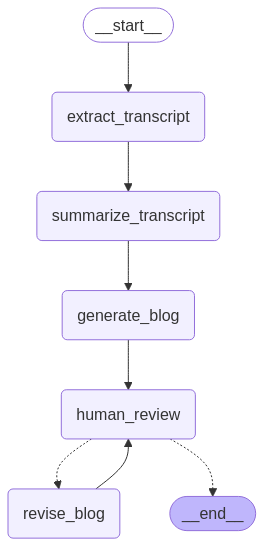

In [10]:
from langgraph.graph import StateGraph, START, END

def should_continue(state: BlogState):
    """ Return the next node to execute """

    # Check if approved:
    
    if state["review_approved"]:
        return END
    
    # Otherwise 
    return "revise_blog"


workflow_buider = StateGraph(BlogState)

## Define nodes
workflow_buider.add_node("extract_transcript", extract_transcript)
workflow_buider.add_node("summarize_transcript", summarize_transcript)
workflow_buider.add_node("generate_blog", generate_blog)
workflow_buider.add_node("human_review", human_review)
workflow_buider.add_node("revise_blog", revise_blog)

## Define execution order
workflow_buider.add_edge(START, "extract_transcript")
workflow_buider.add_edge("extract_transcript", "summarize_transcript")
workflow_buider.add_edge("summarize_transcript", "generate_blog")
workflow_buider.add_edge("generate_blog", "human_review")

# Conditional feedback loop: If rejected, revise the blog and review again
workflow_buider.add_conditional_edges(
    "human_review", should_continue, ["revise_blog", END]
)
workflow_buider.add_edge('revise_blog', "human_review") # Retry loop

workflow = workflow_buider.compile()

from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))

In [11]:
video_url = "https://www.youtube.com/watch?v=9ofL45Mrzj0"
workflow.invoke({"video_url" : video_url})


Extracting transcript for video URL: https://www.youtube.com/watch?v=9ofL45Mrzj0
Transcript successfully extracted : moit and SEMA were husband and wife they
had twin Sons named Sonu and monu both
of them were twins b...

----- In Summarize transcript -----

Summary successfully generated : {'summary_text': 'The video discusses the contrasting behaviors of twin brothers, Sonu and Monu. Sonu is diligent, preparing for tests and projects promptly, while Monu procrastinates and prefers playing to studying. Their contrasting approaches result in Sonu performing well in his tests and Monu receiving reprimands. The father, moit, emphasizes the importance of managing time well to succeed and encourages Monu to adopt a more responsible attitude towards his studies and time management.', 'key_points': ['Sonu and Monu have different approaches to studying and time management.', "Sonu's punctuality and diligence lead to better academic performance.", "Monu's procrastination results in poor perfor

{'video_url': 'https://www.youtube.com/watch?v=9ofL45Mrzj0',
 'transcript': "moit and SEMA were husband and wife they\nhad twin Sons named Sonu and monu both\nof them were twins but their faces were\ncompletely different not only their\nfaces but their thoughts and habits were\nquite different like every day moit\nwakes up on Sunday early in the morning\nand sees that Sonu also wakes up early\non Sunday and is studying sitting\noutside on the couch Sonu son what is\nthe matter that you are getting up so\nearly in the morning to study Papa did\nis a Hindi class test tomorrow and the\nEnglish project has to be given to Mom\nafter 2 days that's why I sat down to\nstudy from morning just then SEMA brings\nbreakfast for Sonu see one of our son is\nSonu who wakes up early in the morning\ntook bath and started studying and the\nother is monu who woke up early in the\nmorning but went out to play Bad ball\nwith his friends just then monu comes\nthere and talks to Mom Mom quickly give\nme break